In [1]:
!pip install pandas numpy matplotlib seaborn nltk tensorflow scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from utils.preprocessing import clean_text
from utils.model_utils import create_rnn_model, evaluate_model

2025-08-01 00:37:47.442033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 00:37:47.448557: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 00:37:47.539052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754008667.642274    6205 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754008667.648860    6205 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754008667.742819    6205 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
train_df = pd.read_csv("data/twitter_training.csv")
val_df = pd.read_csv("data/twitter_validation.csv")

In [5]:
for name, df in [("Train", train_df), ("Validation", val_df)]:
    print(f"\n{name} Shape:", df.shape)
    print(df.info())
    print(df.isnull().sum())
    print(df.head(10))



Train Shape: (74681, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    686
dtype: int64
   2401  Borderlands  Positive  \
0  2401  Borderlands  P

In [6]:
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
print(train_df.shape)
print(val_df.shape)

(73995, 4)
(999, 4)


In [7]:
train_df.head(10)


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


In [8]:
val_df.head(10)

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
5,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
6,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
7,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...
8,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...
9,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...


In [9]:
train_df['Positive'].value_counts()

Positive
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

Text(0.5, 1.0, 'Sentiment Class Distribution')

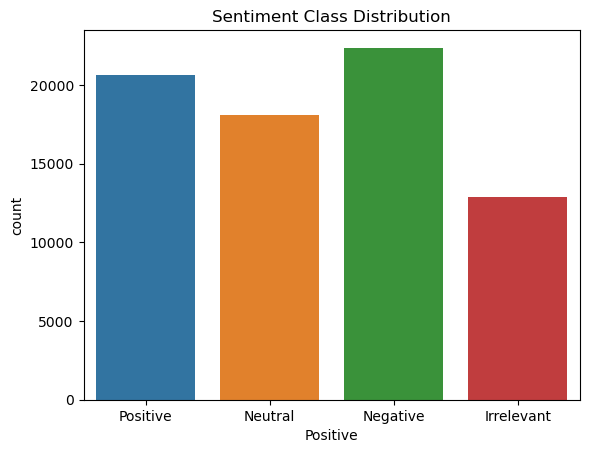

In [10]:
sns.countplot(x='Positive', data=train_df)
plt.title("Sentiment Class Distribution")


Text(0.5, 1.0, 'Tweet Length (Word Count)')

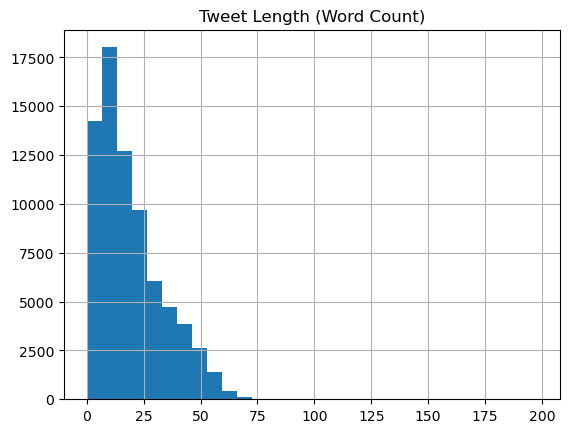

In [11]:
# Text length distribution
train_df['text_length'] = train_df['im getting on borderlands and i will murder you all ,'].apply(lambda x: len(str(x).split()))
train_df['text_length'].hist(bins=30)
plt.title("Tweet Length (Word Count)")

Text(0.5, 1.0, 'Tweet Length by Sentiment Class')

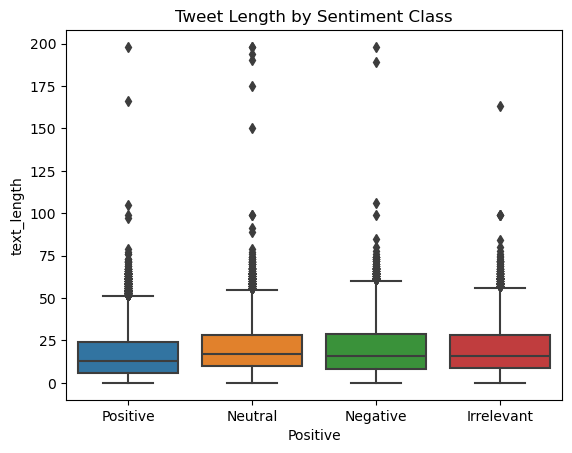

In [12]:
# Class wise text length
sns.boxplot(data=train_df, x='Positive', y='text_length')
plt.title("Tweet Length by Sentiment Class")

In [13]:
# Frequent words per sentiment
from collections import Counter
import re

# create method to identify top words
def top_words_by_sentiment(df, sentiment, n=15):
    words = ' '.join(df[df['Positive'] == sentiment]['im getting on borderlands and i will murder you all ,'].map(clean_text)).split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['Word', 'Count'])

positive_words = top_words_by_sentiment(train_df, 'Positive')
negative_words = top_words_by_sentiment(train_df, 'Negative')
neutral_words = top_words_by_sentiment(train_df, 'Neutral')
irrelevant_words = top_words_by_sentiment(train_df, 'Irrelevant')


In [14]:
# Install wordcloud
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


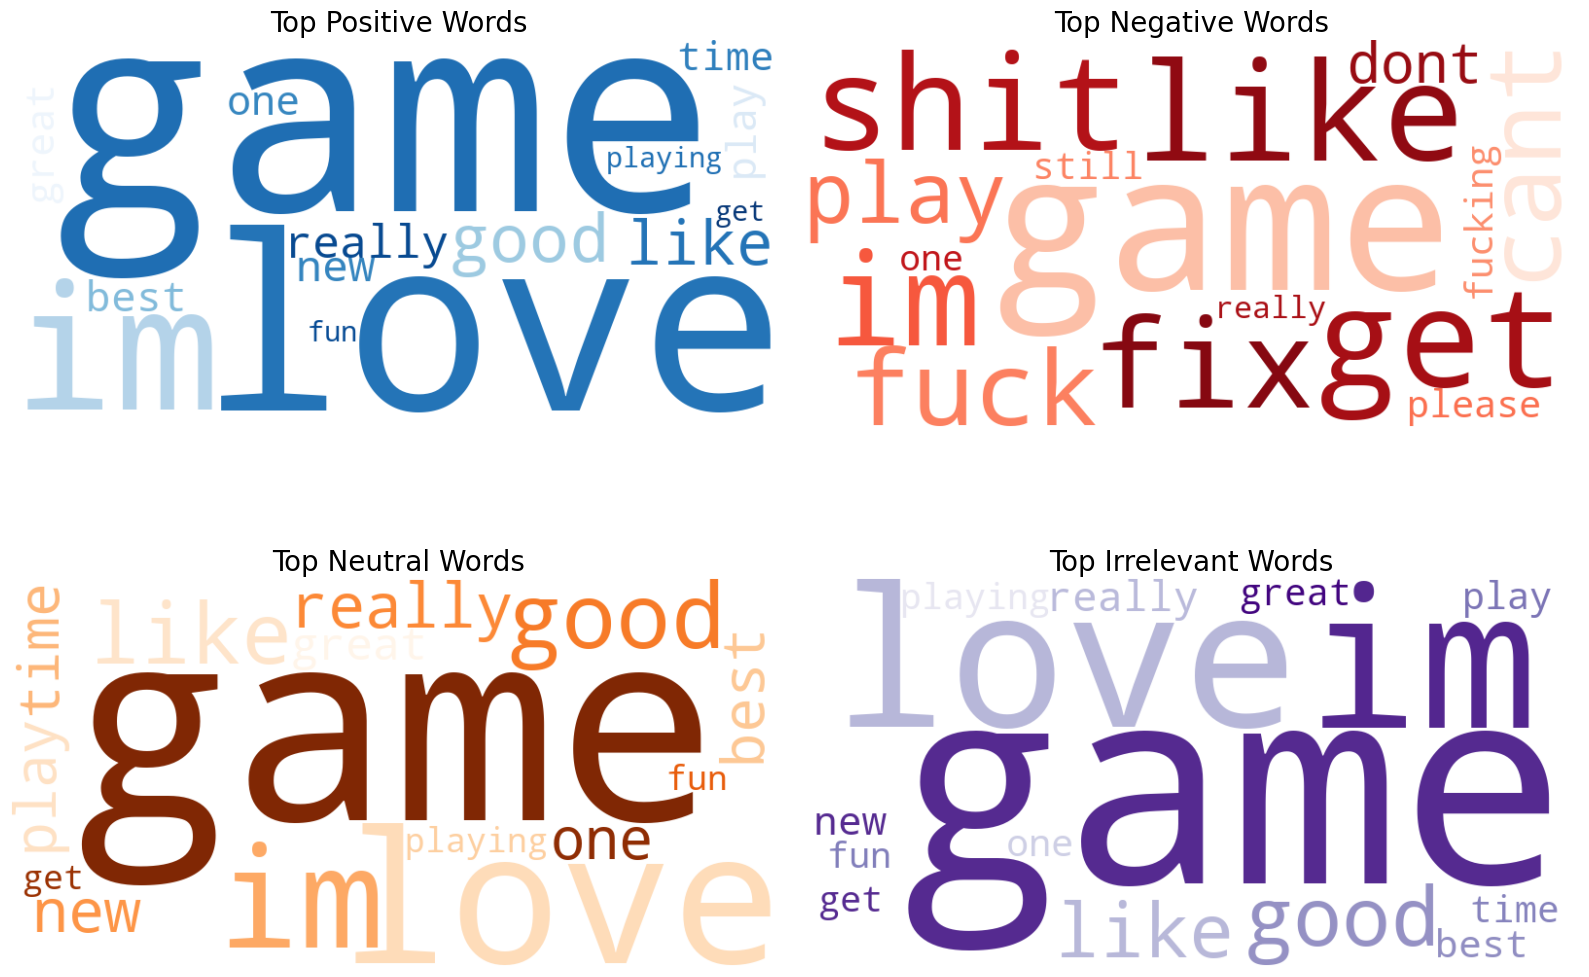

In [15]:
from wordcloud import WordCloud

# Create a dictionary of words and their frequencies
positive_freq = dict(zip(positive_words['Word'], positive_words['Count']))
negative_freq = dict(zip(negative_words['Word'], negative_words['Count']))
neutral_freq = dict(zip(positive_words['Word'], positive_words['Count']))
irrelevant_freq = dict(zip(positive_words['Word'], positive_words['Count']))

# Generate WordClouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(positive_freq)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(negative_freq)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(neutral_freq)
wordcloud_irrelevant = WordCloud(width=800, height=400, background_color='white', colormap='Purples').generate_from_frequencies(irrelevant_freq)

# Plot all four word clouds in 2x2 grid
plt.figure(figsize=(16, 12))

# Positive
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Top Positive Words', fontsize=20)
plt.axis('off')

# Negative
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Top Negative Words', fontsize=20)
plt.axis('off')

# Neutral
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Top Neutral Words', fontsize=20)
plt.axis('off')

# Irrelevant
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_irrelevant, interpolation='bilinear')
plt.title('Top Irrelevant Words', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Drop examples with duplicate text
train_df.drop_duplicates(subset=['im getting on borderlands and i will murder you all ,'], inplace=True)
val_df.drop_duplicates(subset=['I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'], inplace=True)

In [17]:
print(train_df.shape)
print(val_df.shape)

(69490, 5)
(998, 4)


In [18]:
train_df.head(5)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",text_length
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,12
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,10
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,10
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,12
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,10


In [19]:
val_df.head(5)

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [20]:
# Rename columns to create uniformity between training and validation datasets
train_df.rename(columns={'2401': 'Tweet_ID', 'Borderlands': 'Topic', 'Positive': 'Sentiment', 'im getting on borderlands and i will murder you all ,': 'Text'}, inplace=True)
val_df.rename(columns={'3364': 'Tweet_ID', 'Facebook': 'Topic', 'Irrelevant': 'Sentiment',
                       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'Text'}, inplace=True)


In [21]:
train_df.head(5)

,Tweet_ID,Topic,Sentiment,Text,text_length
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,12
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,10
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,10
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,12
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,10


In [22]:
val_df.head(5)

,Tweet_ID,Topic,Sentiment,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [23]:
train_df.drop(columns=['text_length'], inplace=True)

In [24]:
train_df.shape

(69490, 4)

In [25]:
# Check for overlap in Text between dataframes
overlap = set(train_df['Text']).intersection(set(val_df['Text']))
print("Overlap count:", len(overlap))  # Should ideally be 0

Overlap count: 515


In [27]:
# Drop rows from train_df that appear in val_df by Text
train_df = train_df[~train_df['Text'].isin(val_df['Text'])].reset_index(drop=True)

# Sanity check
overlap_check = set(train_df['Text']).intersection(set(val_df['Text']))
print("Final overlap count:", len(overlap_check))  # Should be 0

Final overlap count: 0


In [28]:
train_df.shape

(68975, 4)

In [29]:
val_df.shape

(998, 4)

In [30]:
#Preparing data for RNN
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels to integers
le = LabelEncoder()
train_df['Sentiment_Encoded'] = le.fit_transform(train_df['Sentiment'])
val_df['Sentiment_Encoded'] = le.fit_transform(val_df['Sentiment'])

In [31]:
train_df.shape

(68975, 5)

In [32]:
# For RNN input: tokenize text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

print('Starting RNN implementation...')

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['Text'])


# Split data into training and validation variables
# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['Text'])
X_val = tokenizer.texts_to_sequences(val_df['Text'])


# Pad sequences
X_train = pad_sequences(X_train, maxlen=100)
X_val = pad_sequences(X_val, maxlen=100)


# Extract label values
y_train = train_df['Sentiment_Encoded'].values
y_val = val_df['Sentiment_Encoded'].values


# Create and train model
rnn_model = create_rnn_model(vocab_size=10000)

#Implement early stopping if needed
early_stop = EarlyStopping(
    monitor='val_loss',     # what to monitor
    patience=2,             # wait 2 epochs with no improvement
    restore_best_weights=True  # restore model weights from the best epoch
)
rnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])


# Make predictions
y_pred = rnn_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


# Evaluate model
acc, f1 = evaluate_model(y_val, y_pred_classes)
print(f"Validation Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

print('End')

Starting RNN implementation...


/home/ca2e4b7a-2e36-4985-a31f-4e22feda523e/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-08-01 00:40:09.847467: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 371s 337ms/step - accuracy: 0.4820 - loss: 1.1568 - val_accuracy: 0.7896 - val_loss: 0.5547
Epoch 2/5
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 366s 339ms/step - accuracy: 0.8467 - loss: 0.4355 - val_accuracy: 0.8367 - val_loss: 0.5222
Epoch 3/5
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 367s 340ms/step - accuracy: 0.9149 - loss: 0.2532 - val_accuracy: 0.8226 - val_loss: 0.5528
Epoch 4/5
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 361s 335ms/step - accuracy: 0.9407 - loss: 0.1765 - val_accuracy: 0.8327 - val_loss: 0.5786
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step
Validation Accuracy: 0.8367, F1 Score: 0.8345
End


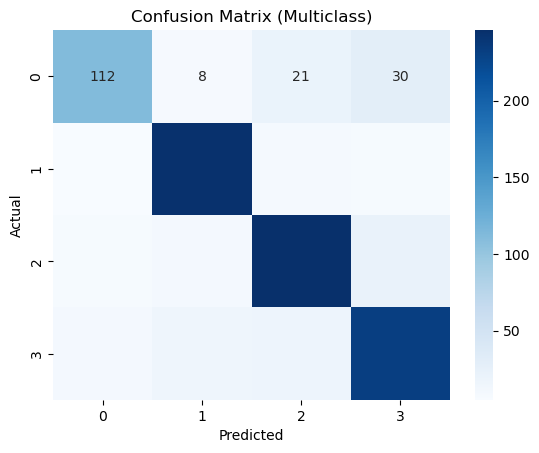

In [33]:
# Evaluation using confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Multiclass)")
plt.show()

In [37]:
# Save model
import keras
keras.saving.save_model(rnn_model, "models/sentiment_rnn.keras")

In [38]:
# Save tokenizer
import pickle
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)